Now we have the raw data produced. Below, we load the csv and print a few lines. We will have frame numbers, the particular keypoints, for each person and the x and y coordinates. We will now process the interpersonal distance between the two persons ID0 and ID1 (which will correspond to the same persons if the two persons are in frame for the entire video). 

In [11]:
import pandas as pd
import glob as glob


inputfollayer1= '../data_sampledatatracked_afterSTEP1/'
# check for a csv in the outputfolder using glob
layeronedat = glob.glob(inputfollayer1 + '*.csv')
print(layeronedat)
ts = pd.read_csv(layeronedat[0])
ts.head()


['../data_sampledatatracked_afterSTEP1\\point_1_2_kam_5_chair_keypoints_data_layer1.csv']


,frame,person,keypoint,x,y
0,3,0,0,0.000000,0.000000
1,3,0,1,0.000000,0.000000
2,3,0,2,0.000000,0.000000
3,3,0,3,0.000000,0.000000
4,3,0,4,1691.768311,977.433472


# Bounding boxes and social proximity

How would we generate the distance between persons of the above data structure? The first thing we need to do, is to compute single position that somehow summarizes the position of all keypoints of the individual. We could for example say, the position of the individual's body is the center of a bounding box, such that the bounding box just outlines the edges of the individual body segments. Or we could say, give me all the keypoint locations and compute the average x and y positions, such that we have the center of mass of the individual.

The below routine goes over each file again and now computes for each frame a bounding box (all the maxima and minima of each dimensions based on the keypoints) and the centroid of that bounding box. We also generate a center of mass, which is the average location. We only do this for the upper body. So for each frame.

We also add a time variable in seconds, which we base on the framerate which we check with each video.

For smoothing we use a [OneEurofilter](https://jaantollander.com/post/noise-filtering-using-one-euro-filter/).

## social distance measures (timeseries data)
- we also compute a smoothness measure between the distance measures
## Extra variables
We will also add some extra variables:
- midpoint between shoulder for person 1 and 2
- distance between shoulder midpoints (also a smoothed version)
- wrist positions
- left hand speed person 1 and 2 (also a smoothed version)
- right hand speed person 1 and 2 (also a smoothed version)

## To do: 
- apply OneEuroFilter


In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import cv2

inputfollayer1= '../data_sampledatatracked_afterSTEP1/'
outputfol = '../data_sampledatatotimeseries_afterSTEP2/'

# first set up one-euro filter
import math


def smoothing_factor(t_e, cutoff):
      r = 2 * math.pi * cutoff * t_e
      return r / (r + 1)


def exponential_smoothing(a, x, x_prev):
      return a * x + (1 - a) * x_prev

# https://jaantollander.com/post/noise-filtering-using-one-euro-filter/
# to cite: https://github.com/jaantollander/OneEuroFilter/blob/master/README.md
class OneEuroFilter:
    def __init__(self, t0, x0, dx0=0.0, min_cutoff=1.0, beta=0.0,
                      d_cutoff=1.0):
          """Initialize the one euro filter."""
          # The parameters.
          self.min_cutoff = float(min_cutoff)
          self.beta = float(beta)
          self.d_cutoff = float(d_cutoff)
          # Previous values.
          self.x_prev = float(x0)
          self.dx_prev = float(dx0)
          self.t_prev = float(t0)

    def __call__(self, t, x):
          """Compute the filtered signal."""
          t_e = max(t - self.t_prev, 1e-6)

          # The filtered derivative of the signal.
          a_d = smoothing_factor(t_e, self.d_cutoff)
          dx = (x - self.x_prev) / t_e
          dx_hat = exponential_smoothing(a_d, dx, self.dx_prev)

          # The filtered signal.
          cutoff = self.min_cutoff + self.beta * abs(dx_hat)
          a = smoothing_factor(t_e, cutoff)
          x_hat = exponential_smoothing(a, x, self.x_prev)

          # Memorize the previous values.
          self.x_prev = x_hat
          self.dx_prev = dx_hat
          self.t_prev = t

          return x_hat
     
# Initialize filters for each signal we want to smooth
def apply_one_euro_filter(time_series, times, min_cutoff=1.0, beta=0.0):
     """Apply One Euro Filter to a time series"""
     # Pre-check inputs
     assert np.all(np.diff(times) > 0), "Time values are not strictly increasing!"
     time_series = np.nan_to_num(time_series, nan=np.nanmean(time_series))  # Replace NaNs
     times = np.nan_to_num(times, nan=np.nanmean(times))
     # Validate inputs before initializing the filter
     if np.isnan(time_series[0]) or np.isnan(times[0]):
          raise ValueError("Invalid initialization values: NaNs detected in input data.")
     f = OneEuroFilter(times[0], time_series[0], min_cutoff=min_cutoff, beta=beta)
     filtered_series = []
     for t, x in zip(times, time_series):
          try:
                filtered_series.append(f(t, x))
          except Exception as e:
                print(f"Error at t={t}, x={x}: {e}")  # Debug info
                filtered_series.append(x)  # Use original value as fallback
     return filtered_series  

# identify all layer one data
layeronedat = glob.glob(inputfollayer1 + '*.csv')

def safe_get(series):
    return series.iloc[0] if not series.empty else np.nan

# Replace the entire person-specific loop section with this vectorized version:
def process_people_data_vectorized(ts, stats):
     """Process people data with stats directly instead of bb_data"""
     # Filter for upper body points and relevant keypoints
     shoulders = ts[ts['keypoint'].isin([5, 6])].groupby(['frame', 'person']).agg({
          'x': 'mean',
          'y': 'mean'
     }).reset_index()
     
     # Process wrists with proper column names
     wrists = (ts[ts['keypoint'].isin([7, 8])]
                 .pivot_table(index=['frame', 'person'],
                                 columns='keypoint',
                                 values=['x', 'y'])
                 .reset_index())
     # Flatten and rename wrist columns properly
     wrists.columns = ['frame', 'person', 
                            'left_x', 'right_x',
                            'left_y', 'right_y']
     
     # Split data for person 0 and 1
     p0_data = stats[stats['person'] == 0].set_index('frame')
     p1_data = stats[stats['person'] == 1].set_index('frame')
     
     # Create result DataFrame with frame index
     result = pd.DataFrame(index=p0_data.index)
     
     # Calculate distances
     result['distance'] = np.sqrt(
          (p0_data['centroid_x'] - p1_data['centroid_x'])**2 + 
          (p0_data['centroid_y'] - p1_data['centroid_y'])**2
     )
     result['distance_com'] = np.sqrt(
          (p0_data['com_x'] - p1_data['com_x'])**2 + 
          (p0_data['com_y'] - p1_data['com_y'])**2
     )
     
     # Process shoulders
     s0 = shoulders[shoulders['person'] == 0].set_index('frame')
     s1 = shoulders[shoulders['person'] == 1].set_index('frame')
     
     result['shoulder_midpoint_p1_x'] = s0['x']
     result['shoulder_midpoint_p1_y'] = s0['y']
     result['shoulder_midpoint_p2_x'] = s1['x']
     result['shoulder_midpoint_p2_y'] = s1['y']
     
     result['distance_shoulder_midpoint'] = np.sqrt(
          (result['shoulder_midpoint_p1_x'] - result['shoulder_midpoint_p2_x'])**2 + 
          (result['shoulder_midpoint_p1_y'] - result['shoulder_midpoint_p2_y'])**2
     )
     
     # Process wrists
     w0 = wrists[wrists['person'] == 0].set_index('frame')
     w1 = wrists[wrists['person'] == 1].set_index('frame')
     
     result['wrist_left_p1_x'] = w0['left_x']
     result['wrist_left_p1_y'] = w0['left_y']
     result['wrist_right_p1_x'] = w0['right_x']
     result['wrist_right_p1_y'] = w0['right_y']
     
     result['wrist_left_p2_x'] = w1['left_x']
     result['wrist_left_p2_y'] = w1['left_y']
     result['wrist_right_p2_x'] = w1['right_x']
     result['wrist_right_p2_y'] = w1['right_y']
     
     return result

# loop over the csv layer 1 data
for vids in layeronedat:
    # Load the CSV file
    ts = pd.read_csv(vids)
    vidname = os.path.basename(vids).split('_keypoints_data_layer1.csv')[0]
    print("working on the following data: " + vidname)
    
    # lets check the sampling rate of the video
    cap = cv2.VideoCapture(inputfollayer1 + vidname + '_annotated_layer1.mp4')
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    
    # Lets set up a data frame with all the variables
    bb_data = pd.DataFrame(columns=['frame', 'person', 'x_min', 'x_max', 'y_min', 'y_max', 'centroid_x', 'centroid_y', 'com_x', 'com_y', 'distance', 'distance_com', 
    'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y',
    'wrist_left_p1_x', 'wrist_left_p1_y', 'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x', 'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y'])
    
    # Fill frame and person data
    for frame in ts['frame'].unique():
         bb_data.loc[2*frame, ('frame', 'person')] = [frame, 0]
         bb_data.loc[2*frame + 1, ('frame', 'person')] = [frame, 1]

    # VECTORIZED SECTION START
    # Filter upper body points once for all frames
    ts_upper = ts[ts['keypoint'] < 11]

    # Calculate all frame-person stats at once
    stats = ts_upper.groupby(['frame', 'person']).agg({
         'x': ['min', 'max', 'mean'],
         'y': ['min', 'max', 'mean']
    }).reset_index()

     # Flatten column names
    stats.columns = ['frame', 'person', 'x_min', 'x_max', 'com_x', 'y_min', 'y_max', 'com_y']

    # Calculate centroids
    stats['centroid_x'] = (stats['x_min'] + stats['x_max']) / 2
    stats['centroid_y'] = (stats['y_min'] + stats['y_max']) / 2

    # Process data directly using stats
    processed_data = process_people_data_vectorized(ts, stats)
    
    # Create final bb_data
    bb_data = pd.merge(
         stats, 
         processed_data.reset_index(), 
         on='frame', 
         how='left'
    )

    # Process time series data
    timeseries_data = bb_data[bb_data['person'] == 0]
    
    # Interpolate NaN values
    nan_cols = timeseries_data.columns[timeseries_data.isna().any()].tolist()
    timeseries_data[nan_cols] = timeseries_data[nan_cols].interpolate()
        # Add time variables
    timeseries_data['time'] = timeseries_data['frame'] * (1/fps)
    # Remove unnecessary columns and add variables
    timeseries_data = timeseries_data.drop(columns='person')
    # Now make the time series uniform, as we have some missing person trackings in the data
    # Resample to uniform time steps (e.g., 0.02s)
    desired_time_step = 1/fps
    time_new = np.arange(timeseries_data['time'].min(), timeseries_data['time'].max(), desired_time_step)

    # Interpolate all columns over the new time grid
    timeseries_data = timeseries_data.set_index('time').reindex(time_new).interpolate().reset_index()
    timeseries_data.rename(columns={'index': 'time'}, inplace=True)
    timeseries_data = timeseries_data.drop_duplicates(subset='time')  # Remove duplicates
    timeseries_data = timeseries_data.sort_values('time')  # Ensure sorted order
    # TODO: we also need to save some information about interpolation to avoid that were doing this too much
    
    # smooth the distance
    timeseries_data['distance_smooth'] = apply_one_euro_filter(
     timeseries_data['distance'].values,
     timeseries_data['time'].values,
     min_cutoff=1.0,  # Adjust these parameters as needed
     beta=0.0
     )
    
  # Apply One Euro Filter to wrist speeds
    for wrist in ['wrist_left_p1', 'wrist_right_p1', 'wrist_left_p2', 'wrist_right_p2']:
          # Calculate speed as before
          timeseries_data[f'{wrist}_speed'] = (timeseries_data[f'{wrist}_x'].diff()**2 + 
                                                          timeseries_data[f'{wrist}_y'].diff()**2)**0.5
          
          # Apply One Euro Filter instead of rolling mean
          timeseries_data[f'{wrist}_speed_smooth'] = apply_one_euro_filter(
                timeseries_data[f'{wrist}_speed'].values,
                timeseries_data['time'].values,
                min_cutoff=1.0,  # Adjust these parameters as needed
                beta=0.0
          )
    
    # Fill NaN values
    timeseries_data = timeseries_data.fillna(method='bfill')
    
    # Save the processed data
    output_columns = ['time','frame', 'distance', 'distance_smooth', 'distance_com', 'distance_shoulder_midpoint', 
                          'shoulder_midpoint_p1_x', 'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y', 'shoulder_midpoint_p2_y',
                          'wrist_left_p1_x', 'wrist_left_p1_y', 'wrist_right_p1_x', 'wrist_right_p1_y',
                          'wrist_left_p2_x', 'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y',
                          'wrist_left_p1_speed', 'wrist_right_p1_speed', 'wrist_left_p2_speed', 'wrist_right_p2_speed',
                          'wrist_left_p1_speed_smooth', 'wrist_right_p1_speed_smooth', 'wrist_left_p2_speed_smooth', 
                          'wrist_right_p2_speed_smooth']
    
    timeseries_data[output_columns].to_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv', index=False)

working on the following data: point_1_2_kam_5_chair


ValueError: cannot reindex from a duplicate axis

In [61]:
# Print final columns
timeseries_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv')
print('variables we have saved are the following: ', timeseries_data.columns)    
timeseries_data.head()

variables we have saved are the following:  Index(['time', 'frame', 'distance', 'distance_smooth', 'distance_com',
       'distance_shoulder_midpoint', 'shoulder_midpoint_p1_x',
       'shoulder_midpoint_p2_x', 'shoulder_midpoint_p1_y',
       'shoulder_midpoint_p2_y', 'wrist_left_p1_x', 'wrist_left_p1_y',
       'wrist_right_p1_x', 'wrist_right_p1_y', 'wrist_left_p2_x',
       'wrist_left_p2_y', 'wrist_right_p2_x', 'wrist_right_p2_y',
       'wrist_left_p1_speed', 'wrist_right_p1_speed', 'wrist_left_p2_speed',
       'wrist_right_p2_speed', 'wrist_left_p1_speed_smooth',
       'wrist_right_p1_speed_smooth', 'wrist_left_p2_speed_smooth',
       'wrist_right_p2_speed_smooth'],
      dtype='object')


,time,frame,distance,distance_smooth,distance_com,distance_shoulder_midpoint,shoulder_midpoint_p1_x,shoulder_midpoint_p2_x,shoulder_midpoint_p1_y,shoulder_midpoint_p2_y,...,wrist_right_p2_x,wrist_right_p2_y,wrist_left_p1_speed,wrist_right_p1_speed,wrist_left_p2_speed,wrist_right_p2_speed,wrist_left_p1_speed_smooth,wrist_right_p1_speed_smooth,wrist_left_p2_speed_smooth,wrist_right_p2_speed_smooth
0,0.06,3.0,35.632207,522.675281,109.536014,91.816519,0.000000,214.658588,0.000000,476.61355,...,284.892682,344.606104,0.000000,0.0,41.580227,149.04034,5.565118,3.611719,4.289425,4.341865
1,0.08,4.0,35.632207,522.675281,109.536014,91.816519,0.000000,214.658588,0.000000,476.61355,...,284.892682,344.606104,0.000000,0.0,41.580227,149.04034,4.943855,3.208524,4.289425,4.341865
2,0.10,5.0,35.632207,522.675281,109.536014,91.816519,222.622396,214.658588,150.239665,476.61355,...,284.892682,344.606104,511.740876,0.0,41.580227,149.04034,61.520248,2.850340,4.289425,4.341865
3,0.12,6.0,35.632207,522.675281,109.536014,91.816519,445.244792,214.658588,300.479329,476.61355,...,284.892682,344.606104,511.740876,0.0,41.580227,149.04034,111.780723,2.532142,4.289425,4.341865
4,0.14,7.0,35.632207,522.675281,109.536014,91.816519,667.867188,214.658588,450.718994,476.61355,...,284.892682,344.606104,511.740876,0.0,41.580227,149.04034,156.430359,2.249465,4.289425,4.341865


In [60]:
timeseries_data

,time,frame,distance,distance_smooth,distance_com,distance_shoulder_midpoint,shoulder_midpoint_p1_x,shoulder_midpoint_p2_x,shoulder_midpoint_p1_y,shoulder_midpoint_p2_y,...,wrist_right_p2_x,wrist_right_p2_y,wrist_left_p1_speed,wrist_right_p1_speed,wrist_left_p2_speed,wrist_right_p2_speed,wrist_left_p1_speed_smooth,wrist_right_p1_speed_smooth,wrist_left_p2_speed_smooth,wrist_right_p2_speed_smooth
0,0.06,3.0,35.632207,522.675281,109.536014,91.816519,0.000000,214.658588,0.000000,476.613550,...,284.892682,344.606104,0.000000,0.0,41.580227,149.04034,5.565118e+00,3.611719e+00,4.289425e+00,4.341865e+00
1,0.08,4.0,35.632207,522.675281,109.536014,91.816519,0.000000,214.658588,0.000000,476.613550,...,284.892682,344.606104,0.000000,0.0,41.580227,149.04034,4.943855e+00,3.208524e+00,4.289425e+00,4.341865e+00
2,0.10,5.0,35.632207,522.675281,109.536014,91.816519,222.622396,214.658588,150.239665,476.613550,...,284.892682,344.606104,511.740876,0.0,41.580227,149.04034,6.152025e+01,2.850340e+00,4.289425e+00,4.341865e+00
3,0.12,6.0,35.632207,522.675281,109.536014,91.816519,445.244792,214.658588,300.479329,476.613550,...,284.892682,344.606104,511.740876,0.0,41.580227,149.04034,1.117807e+02,2.532142e+00,4.289425e+00,4.341865e+00
4,0.14,7.0,35.632207,522.675281,109.536014,91.816519,667.867188,214.658588,450.718994,476.613550,...,284.892682,344.606104,511.740876,0.0,41.580227,149.04034,1.564304e+02,2.249465e+00,4.289425e+00,4.341865e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20841,416.88,15495.0,520.794617,520.794617,449.928751,1174.540369,1484.087830,342.890854,850.064392,572.189346,...,563.880493,689.722107,0.000000,0.0,0.000000,0.00000,5.342534e-274,3.932246e-275,4.966985e-275,3.754466e-275
20842,416.90,15495.0,520.794617,520.794617,449.928751,1174.540369,1484.087830,342.890854,850.064392,572.189346,...,563.880493,689.722107,0.000000,0.0,0.000000,0.00000,4.746119e-274,3.493269e-275,4.412494e-275,3.335336e-275
20843,416.92,15495.0,520.794617,520.794617,449.928751,1174.540369,1484.087830,342.890854,850.064392,572.189346,...,563.880493,689.722107,0.000000,0.0,0.000000,0.00000,4.216285e-274,3.103297e-275,3.919905e-275,2.962995e-275
20844,416.94,15495.0,520.794617,520.794617,449.928751,1174.540369,1484.087830,342.890854,850.064392,572.189346,...,563.880493,689.722107,0.000000,0.0,0.000000,0.00000,3.745599e-274,2.756860e-275,3.482305e-275,2.632220e-275


# Plotting and animating
Below we set up a plotting function that we will use for our animations.

d:\Programs\Conda_packages\envs\motionbert\lib\site-packages\ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


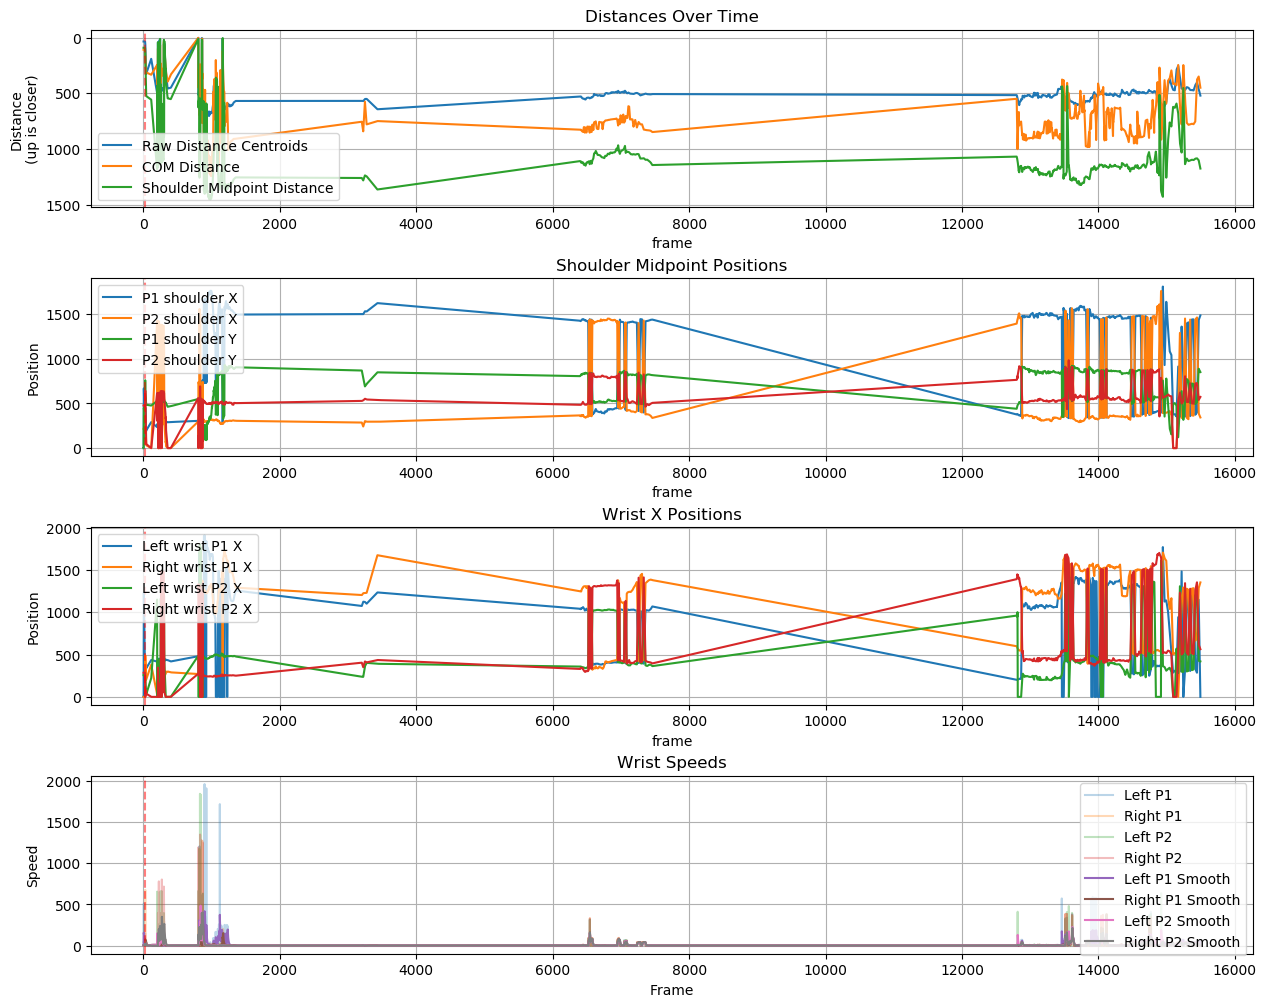

In [57]:
# plot the distance
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import cv2

# Load a sample CSV file with distance data using glob
timeseries_data = pd.read_csv(glob.glob(outputfol + '*processed_data*.csv')[0])

# make a function out of this
def plot_timeseries(timeseries_data, current_frame=None, figsize=(15, 12)):
     """
     Create a comprehensive visualization of motion analysis data.
     
     Parameters:
     -----------
     timeseries_data : pandas.DataFrame
          DataFrame containing all the motion analysis columns
     current_frame : int, optional
          Frame number to mark with vertical line
     figsize : tuple, optional
          Figure size in inches (width, height)
     """
     # Create figure with subplots
     fig = plt.figure(figsize=figsize)
     
     # Define grid layout
     gs = plt.GridSpec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.4)
     
     # 1. Distance Plots
     ax1 = fig.add_subplot(gs[0])
     sns.lineplot(data=timeseries_data, x='frame', y='distance', label='Raw Distance Centroids', ax=ax1)
     sns.lineplot(data=timeseries_data, x='frame', y='distance_com', label='COM Distance', ax=ax1)
     sns.lineplot(data=timeseries_data, x='frame', y='distance_shoulder_midpoint', label='Shoulder Midpoint Distance', ax=ax1)
     ax1.set_title('Distances Over Time')
     ax1.set_ylabel('Distance\n(up is closer)')
     ax1.grid(True)
     ax1.invert_yaxis()
     
     # 2. Shoulder Midpoint Positions
     ax2 = fig.add_subplot(gs[1])
     sns.lineplot(data=timeseries_data, x='frame', y='shoulder_midpoint_p1_x', label='P1 shoulder X', ax=ax2)
     sns.lineplot(data=timeseries_data, x='frame', y='shoulder_midpoint_p2_x', label='P2 shoulder X', ax=ax2)
     sns.lineplot(data=timeseries_data, x='frame', y='shoulder_midpoint_p1_y', label='P1 shoulder Y', ax=ax2)
     sns.lineplot(data=timeseries_data, x='frame', y='shoulder_midpoint_p2_y', label='P2 shoulder Y', ax=ax2)
     ax2.set_title('Shoulder Midpoint Positions')
     ax2.set_ylabel('Position')
     ax2.grid(True)
     
     # 3. Wrist Positions
     ax3 = fig.add_subplot(gs[2])
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_left_p1_x', label='Left wrist P1 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_right_p1_x', label='Right wrist P1 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_left_p2_x', label='Left wrist P2 X', ax=ax3)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_right_p2_x', label='Right wrist P2 X', ax=ax3)
     ax3.set_title('Wrist X Positions')
     ax3.set_ylabel('Position')
     ax3.grid(True)
     
     # 4. Wrist Speeds
     ax4 = fig.add_subplot(gs[3])
     # Raw speeds
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_left_p1_speed', label='Left P1', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_right_p1_speed', label='Right P1', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_left_p2_speed', label='Left P2', alpha=0.3, ax=ax4)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_right_p2_speed', label='Right P2', alpha=0.3, ax=ax4)
     # Smoothed speeds
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_left_p1_speed_smooth', label='Left P1 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_right_p1_speed_smooth', label='Right P1 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_left_p2_speed_smooth', label='Left P2 Smooth', ax=ax4)
     sns.lineplot(data=timeseries_data, x='frame', y='wrist_right_p2_speed_smooth', label='Right P2 Smooth', ax=ax4)
     ax4.set_title('Wrist Speeds')
     ax4.set_ylabel('Speed')
     ax4.grid(True)
     
     # Add vertical line for current frame if specified
     if current_frame is not None:
          for ax in [ax1, ax2, ax3, ax4]:
                ax.axvline(x=current_frame, color='r', linestyle='--', alpha=0.5)
     
     # Set common x-label
     plt.xlabel('Frame')
     
     # Adjust layout
     plt.tight_layout()
     
     return fig


test = plot_timeseries(timeseries_data, 20)


Note of course, that is is now not difficult to just load a file and compute summary statistics for this particular video (or trial). 

the mean distance: 522.1612758812951
standard deviation:  71.51720819303596


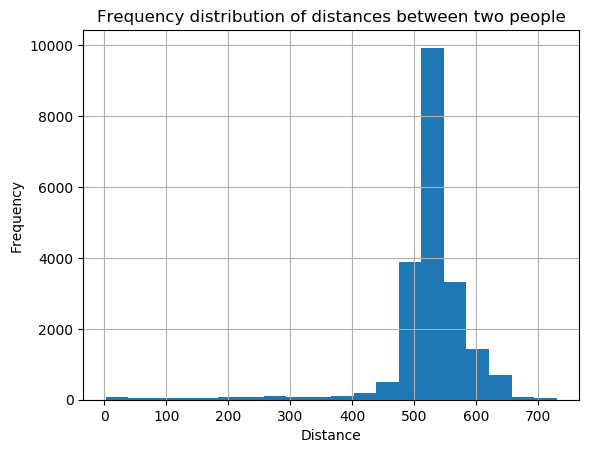

In [45]:
import pandas as pd
from scipy.integrate import simps

# Load a CSV file with distance data using glob
timeseries_data = pd.read_csv(glob.glob(outputfol + '*processed_data*.csv')[0])

# computing some relevant summary statistcs (mean, sd, and frequency distribution)
mean_distance = timeseries_data['distance'].mean()
sd_distance = timeseries_data['distance'].std()
timeseries_data['distance'].plot.hist(bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Frequency distribution of distances between two people')
plt.grid()
print('the mean distance:',  mean_distance)
print('standard deviation: ', sd_distance)

In [46]:
# specifically we might be interested in computing the smoothness of the distance

def dimensionless_squared_jerk_from_speed(distance, time):
     """
     Calculate the dimensionless squared jerk metric from speed data.
     
     Parameters:
     -----------
     distance : array_like
          Distance data points (first derivative of position), should be a 1D numpy array
     time : array_like
          Time points corresponding to the distance data, should be a 1D numpy array
     
     Returns:
     --------
     float
          Dimensionless squared jerk metric
     """
     # Calculate the time step
     dt = np.diff(time)[0]
     
     speed = np.gradient(distance, dt)

     # Calculate acceleration (first derivative of speed)
     acceleration = np.gradient(speed, dt)
     
     # Calculate jerk (second derivative of speed)
     jerk = np.gradient(acceleration, dt)
     
     # Calculate movement duration (D)
     movement_duration = time[-1] - time[0]
     
     # Calculate movement amplitude by integrating speed to get distance
     position = simps(speed, time)  # Total distance traveled
     movement_amplitude = position  # In this case, amplitude is total distance
     
     # Calculate the squared jerk
     squared_jerk = jerk ** 2
     
     # Integrate the squared jerk
     integrated_squared_jerk = simps(squared_jerk, time)
     
     # Calculate the dimensionless squared jerk
     dimensionless_jerk = integrated_squared_jerk * (movement_duration**5 / movement_amplitude**2)
     
     return dimensionless_jerk

# Calculate the dimensionless squared jerk for the distance data and print
dimensionless_jerk = dimensionless_squared_jerk_from_speed(timeseries_data['distance_smooth'].values, timeseries_data['time'].values)
print('Dimensionless squared jerk:', dimensionless_jerk)

Dimensionless squared jerk: 5.583104720683134e+24


In the following chunk, we loop over each frame of the tracked video, and then we generate a figure with the vertical bar at the precise frame number, and plot the timeseries plot onto the video (in the lower region). In this way we can show the changing social proximity.

  0%|          | 7/20850 [00:40<33:22:10,  5.76s/it]


KeyboardInterrupt: 

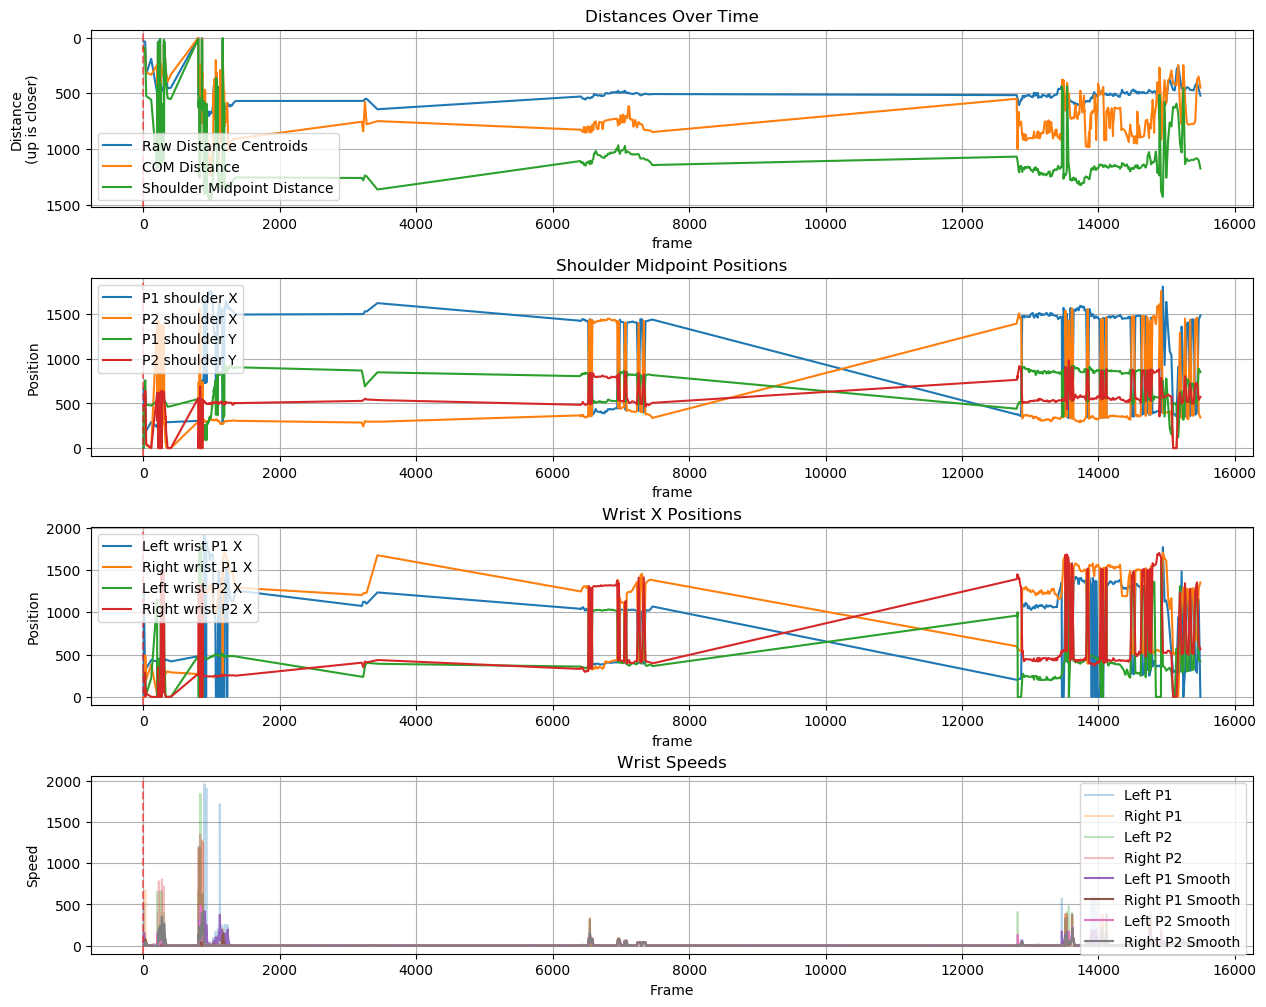

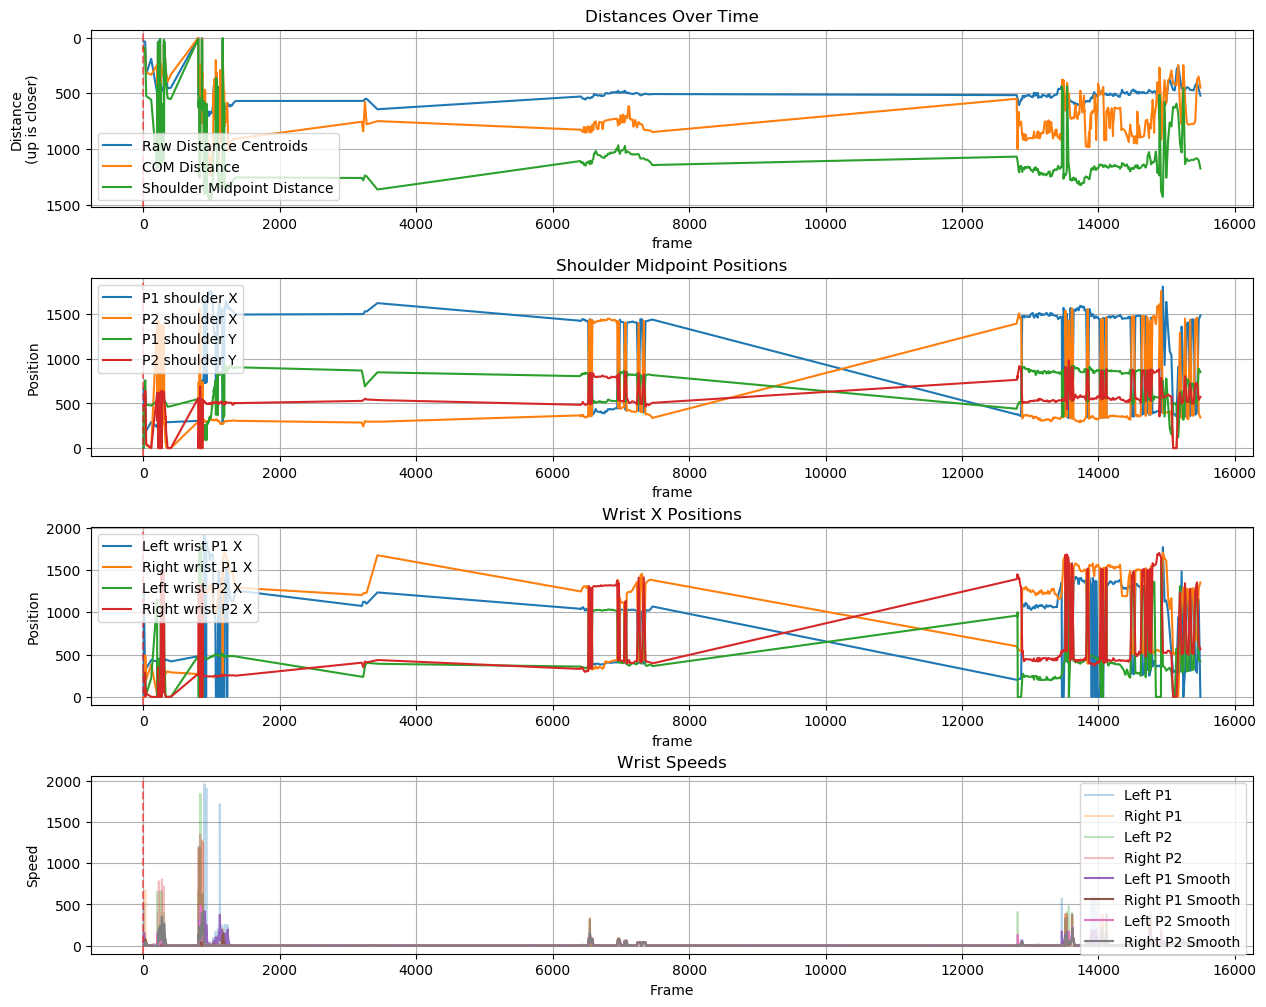

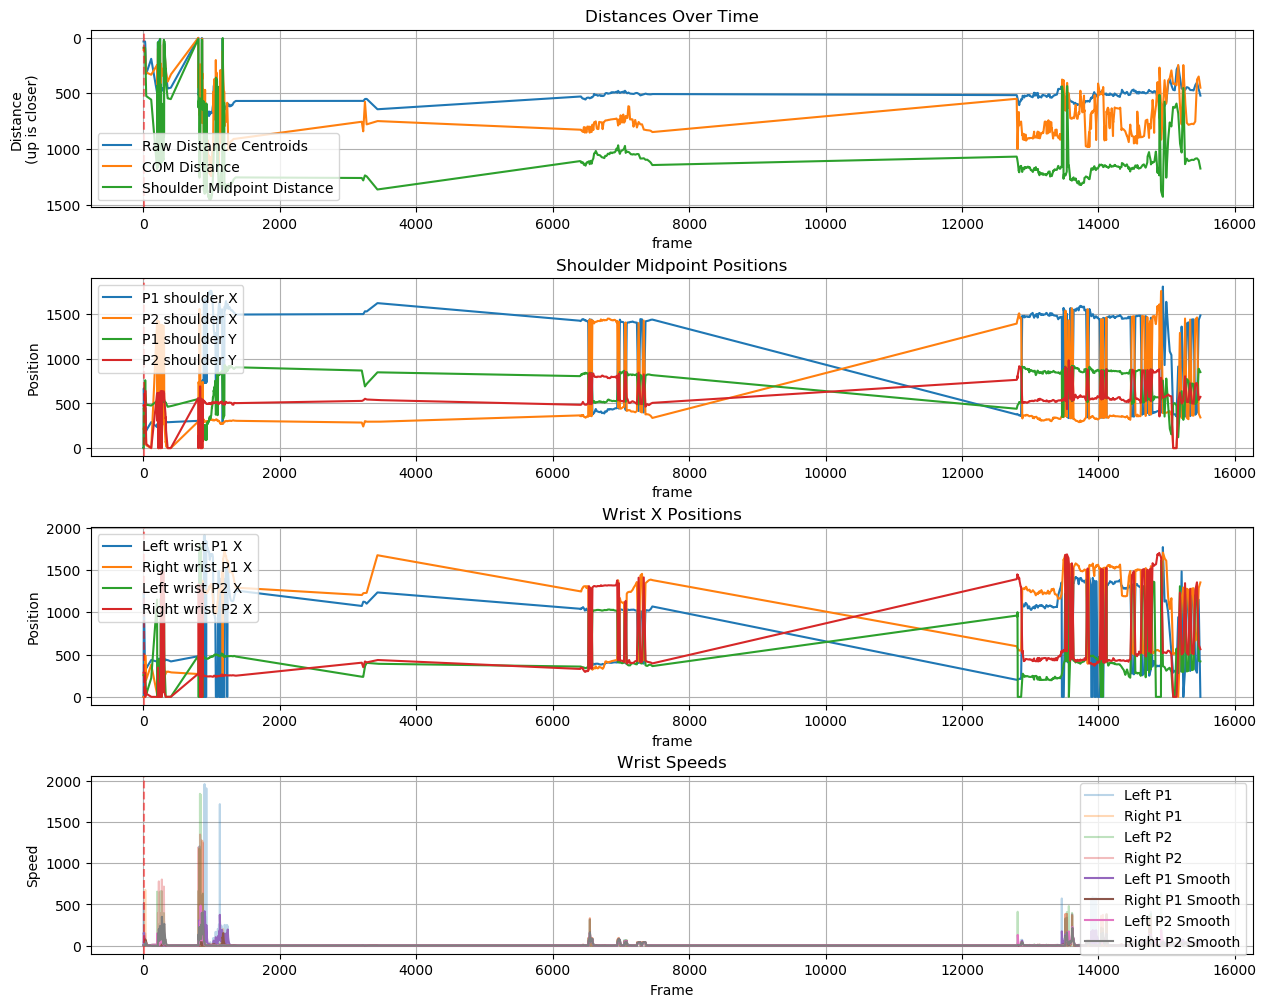

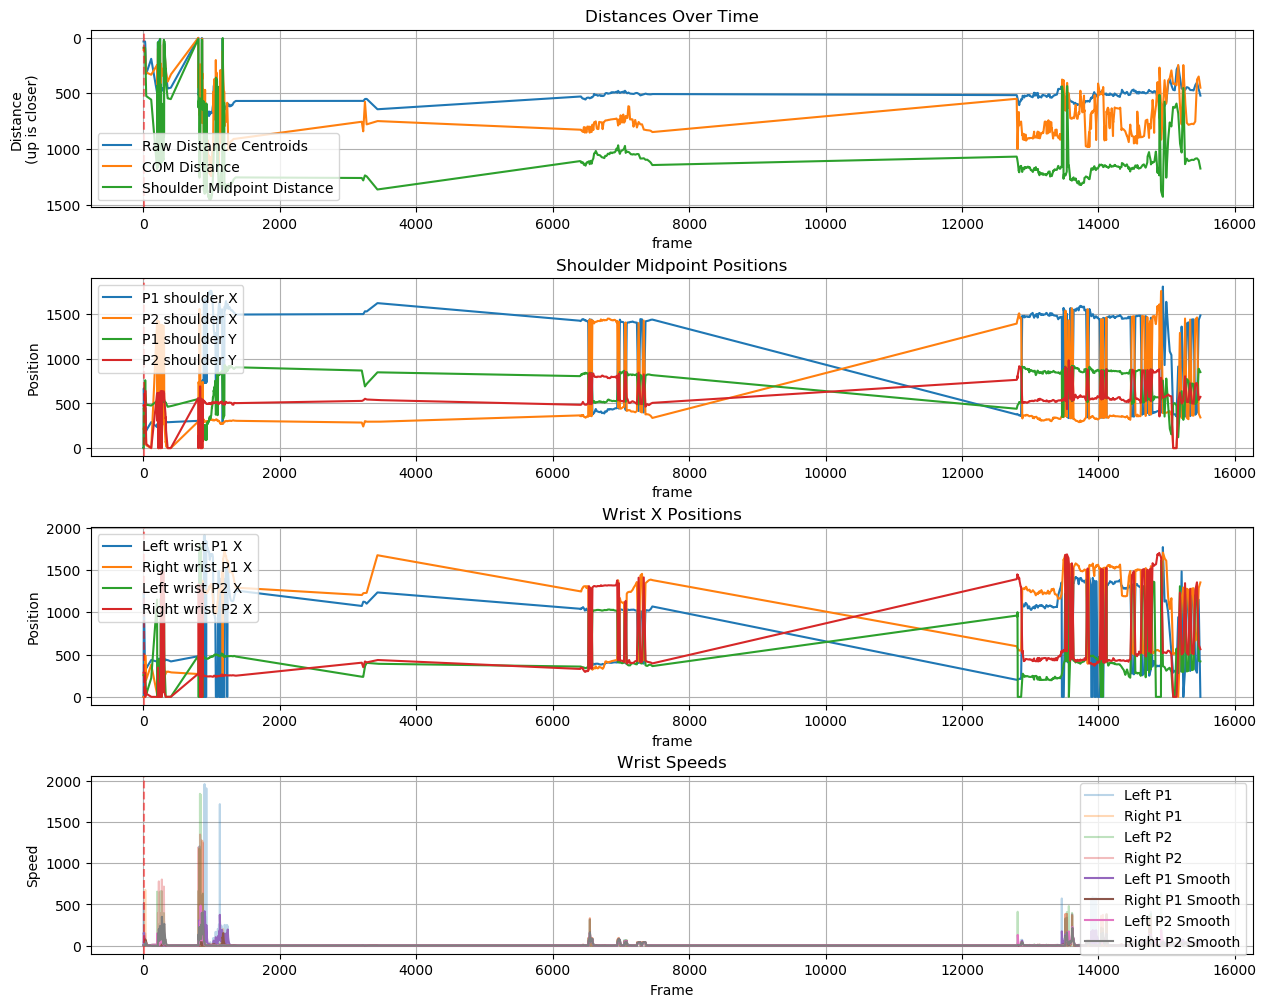

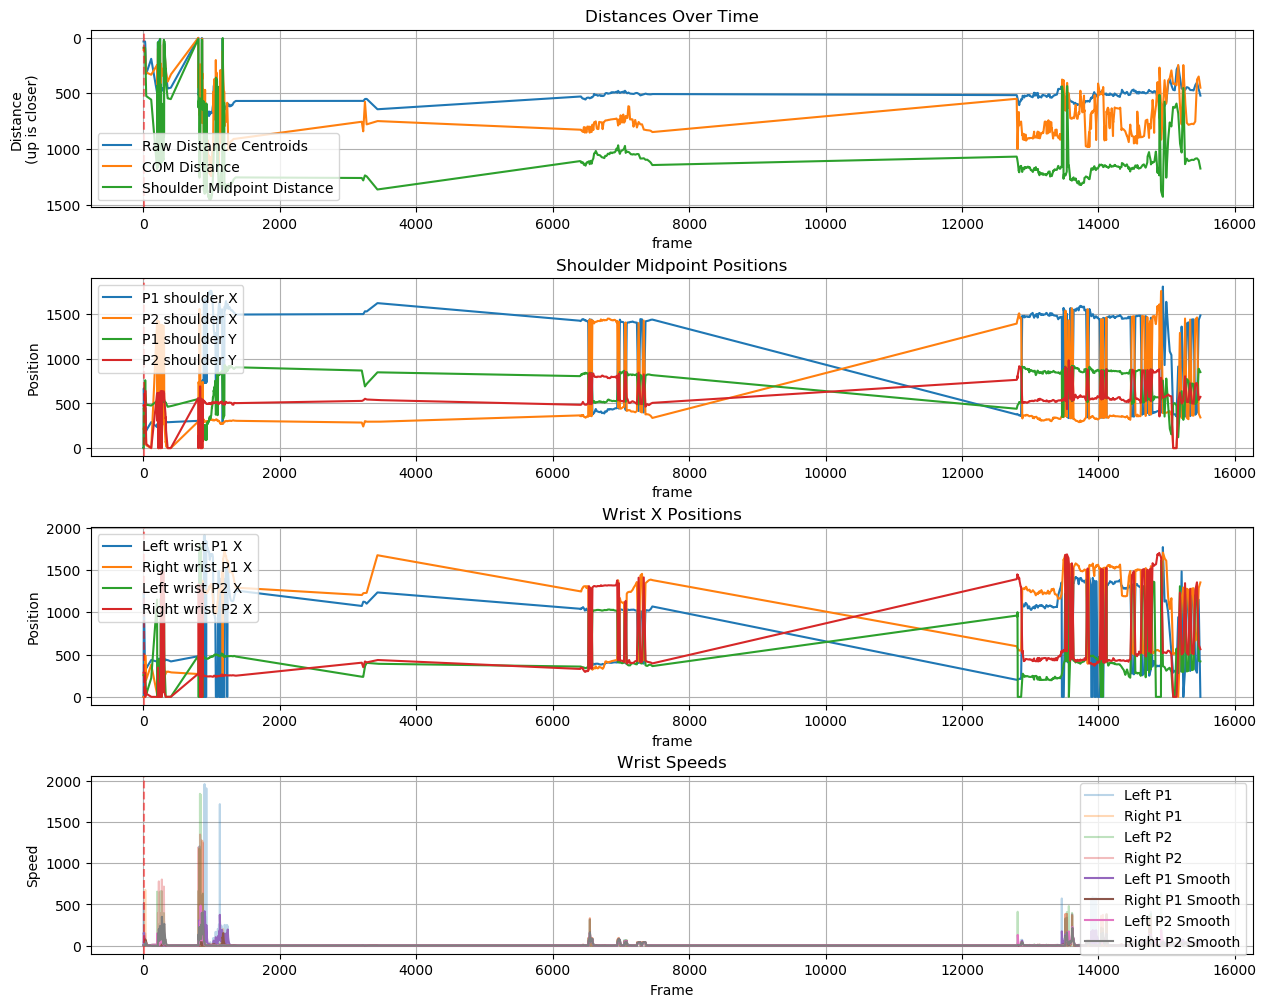

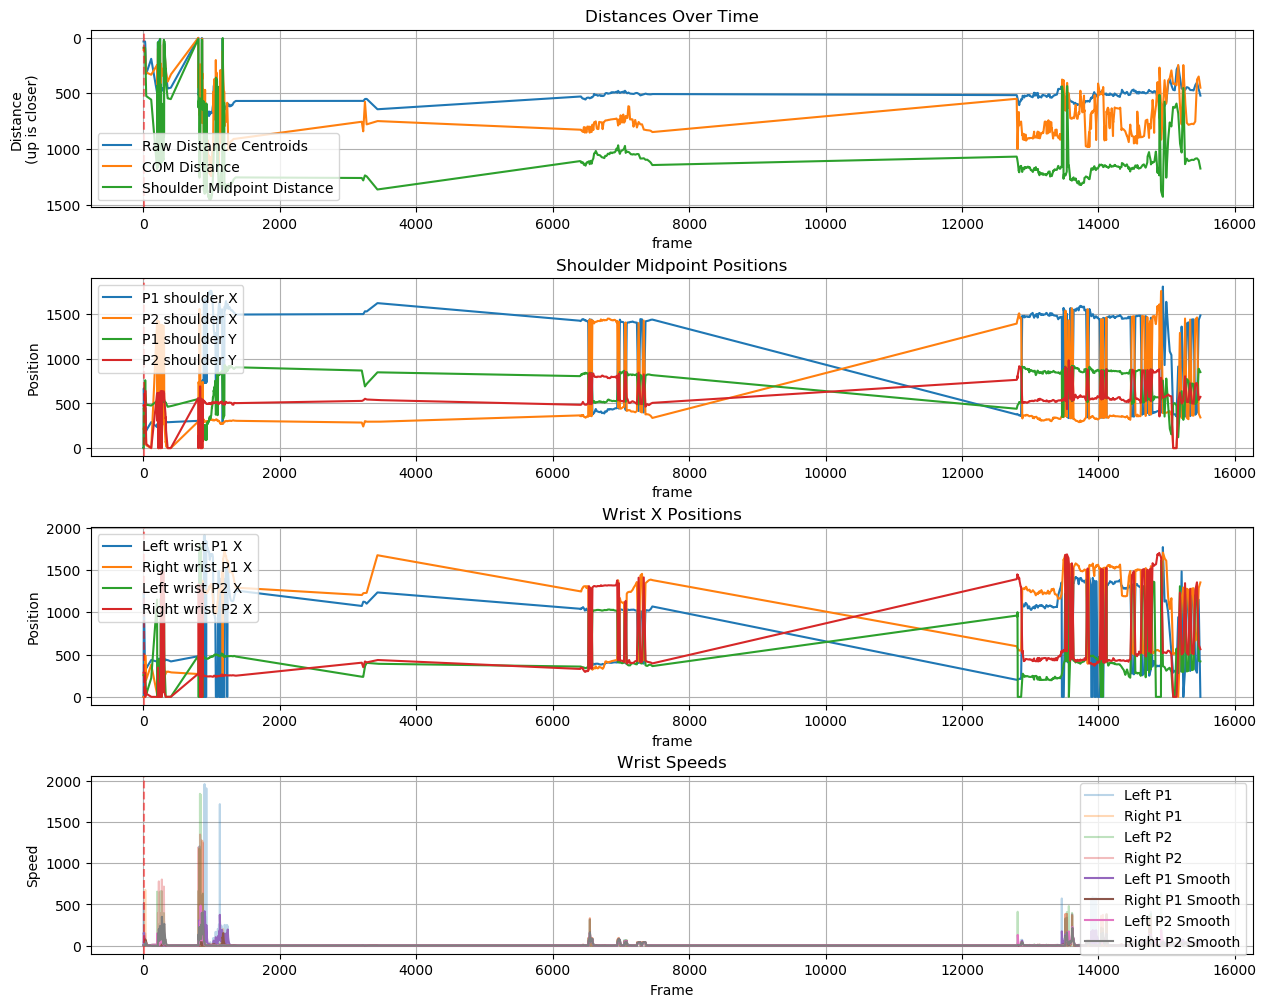

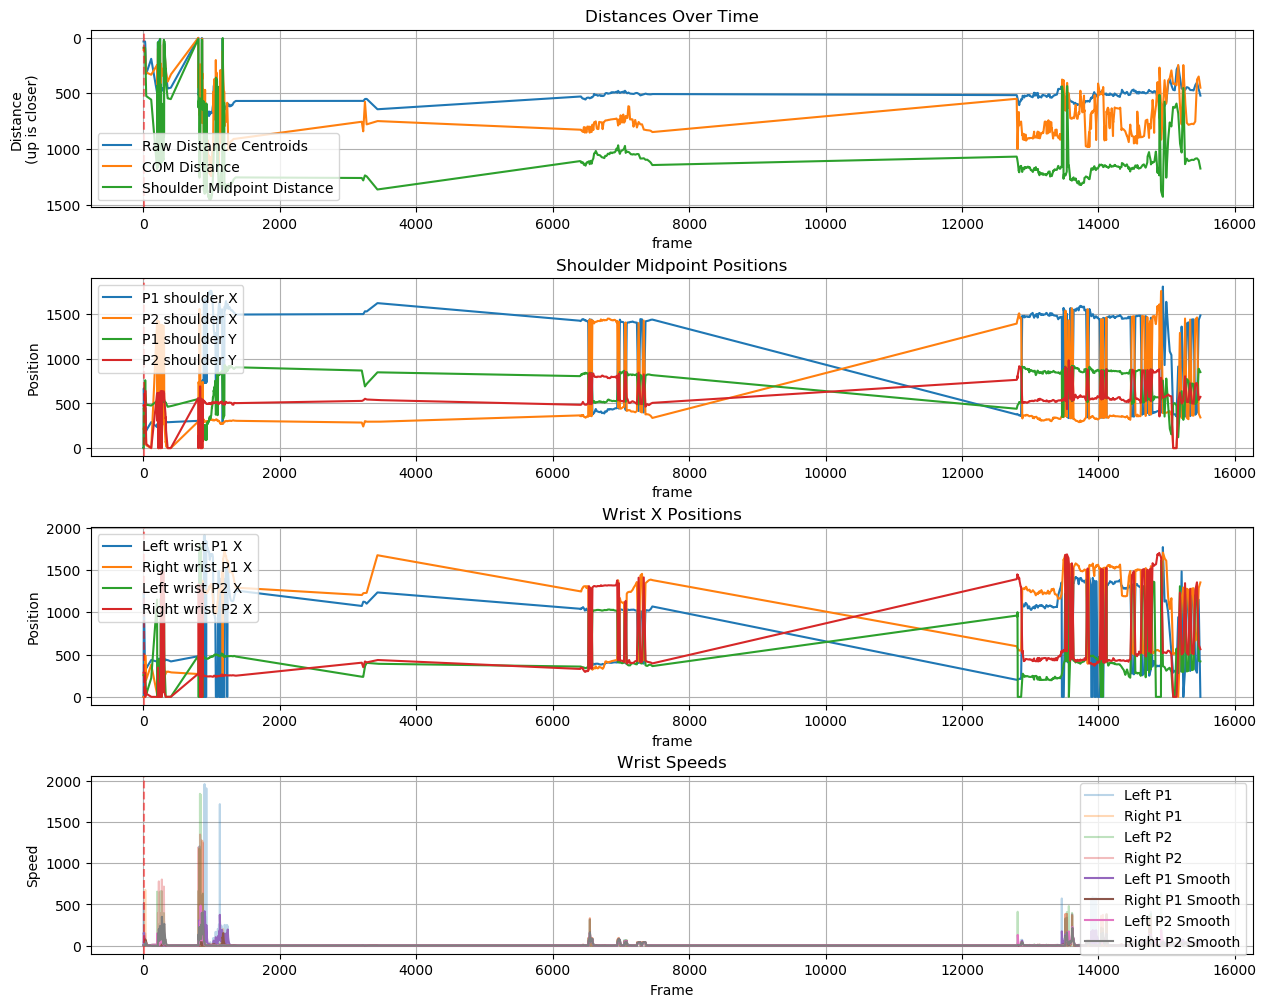

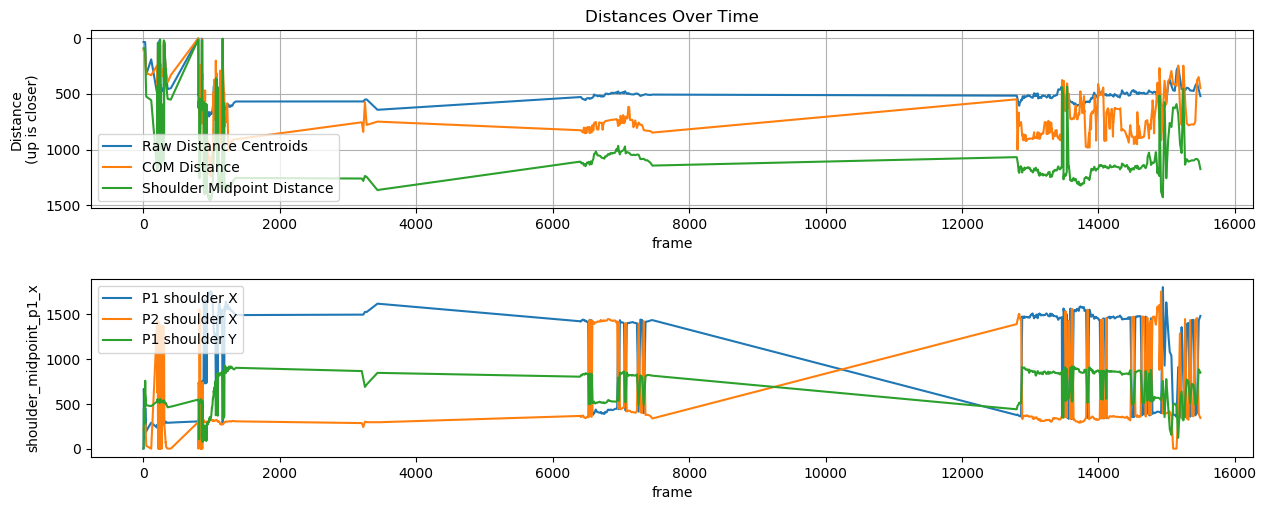

In [ ]:
import tqdm
import tempfile

#check all videos with layer 1
inputfol = '../data_sampledatatracked_afterSTEP1/'
allvidsnew = glob.glob(inputfol + '*_layer1.mp4')

# make an annimation
for vids in allvidsnew:
     vidname = os.path.basename(vids)
     # remove substring "_annotated_layer1"
     lab = "_annotated_layer1"
     vidname = vidname.replace(lab, "")     
     vidname = vidname[:-4]
     
          # Load the CSV file
     timeseries_data = pd.read_csv(outputfol + '/' + vidname + '_processed_data_layer2.csv')
     # load the video file in opencv
     cap = cv2.VideoCapture(vids)
     # Get video properties
     fps = int(cap.get(cv2.CAP_PROP_FPS))
     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
     # Define the output video writer
     output_path = outputfol + '/' + vidname + '_distance_layer2.mp4'
     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
     out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
     # loop over the frames with tqdm processbar
     frame_count = 0
     for _ in tqdm.tqdm(range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
          # read the frame
          success, frame = cap.read()
          if not success:
                break
          # plot the distance
          plot = plot_timeseries(timeseries_data, frame_count)
          # save the plot to a temp file in the output folder
          with tempfile.NamedTemporaryFile(suffix='.png', delete=False, dir=outputfol) as f:          
                plot.savefig(f.name)
                slice_start = 2 * (height // 3)
                slice_height = frame.shape[0] - slice_start

                # Resize dynamically
                plot_img = cv2.resize(plot_img, (width, slice_height))

                # Assign without shape mismatch
                frame[slice_start:slice_start + slice_height, :, :] = plot_img
               

                # write the frame to the output video
                # downsize the video by a half
                out.write(frame)
                      
          frame_count += 1
     # Release everything
     cap.release()
     out.release()
     print(f"Output video saved as {output_path}")
     # delete all temp files
     for file in glob.glob(outputfol + '/*.png'):
          os.remove(file)